In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import albumentations as alb
import cv2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pydicom
import pydicom  as pdcm

     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [4]:
project_path = "/content/drive/My Drive/"

In [5]:
from zipfile import ZipFile

with ZipFile('/content/drive/My Drive/rsna-pneumonia-detection-challenge.zip', 'r') as zipdata:
    data = zipdata.open('stage_2_train_labels.csv')

In [6]:
import pandas as pd

df = pd.read_csv(data)

In [7]:
print('First five rows of Training set:\n', df.head())
print(df.iloc[0])

First five rows of Training set:
                               patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [8]:
df.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target'], dtype='object')

In [9]:
df.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64

In [10]:
df.shape[0]

30227

In [11]:
df.shape[1]

6

In [12]:
# Number of duplicates in patientId:
print('Number of unique patientId are: {}'.format(df['patientId'].nunique()))

Number of unique patientId are: 26684


In [13]:
clean_df = df.drop_duplicates('patientId')

In [14]:
clean_df.shape[0]

26684

## Distribution of Patients with and without Pneumonia

#### Patients with Pneumonia

In [15]:
## Patients without Pneumonia
wtPnm = df[df.Target == 1]
wtPnm 

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1
...,...,...,...,...,...,...
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,316.0,504.0,179.0,273.0,1
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


#### Patients without Pneumonia

In [16]:
## Patients without Pneumonia
WtoPnm = df[df.Target == 0]
WtoPnm

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
30216,c1cf3255-d734-4980-bfe0-967902ad7ed9,NaN,NaN,NaN,NaN,0
30217,c1e228e4-b7b4-432b-a735-36c48fdb806f,NaN,NaN,NaN,NaN,0
30218,c1e3eb82-c55a-471f-a57f-fe1a823469da,NaN,NaN,NaN,NaN,0
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0


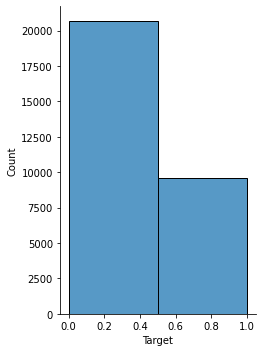

In [17]:
# Distribution of Pnemonia among the patients
dp_Pnem_cnt = sns.displot(df.Target, bins=2, height=5, aspect=0.75)

In [18]:
print(f'Percentage of Patients with Pneumonia :  {round(wtPnm.shape[0]/df.shape[0]*100, 0)}% ')
print(f'Percentage of Patients without Pneumonia  {round(WtoPnm.shape[0]/df.shape[0]*100, 0)}%')

Percentage of Patients with Pneumonia :  32.0% 
Percentage of Patients without Pneumonia  68.0%


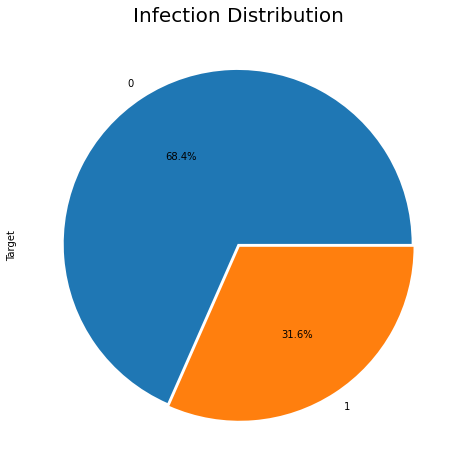

In [19]:
fig = plt.figure(figsize =(8,8))
ax1 = fig.add_subplot(111)
ax1.title.set_text("Infection Distribution")
ax1.title.set_fontsize(20)

dp_inf = df.Target.value_counts()

dp_inf.plot.pie(autopct="%1.1f%%", ax=ax1, explode=[0.01,0.01])

plt.show()

### Identify Bounding Box 

In [20]:
# Checking nulls in bounding box columns:
print('Number of nulls in bounding box columns: {}'.format(df[['x', 'y', 'width', 'height']].isnull().sum().to_dict()))

Number of nulls in bounding box columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}


In [21]:
Bbox = df.groupby('patientId').size().to_frame('Boxes').reset_index()
df = df.merge(Bbox, on = 'patientId', how = 'left')
(Bbox.groupby('Boxes').size().to_frame('Patient Count').reset_index().set_index('Boxes').sort_values(by = 'Boxes'))

,Patient Count
Boxes,
1,23286
2,3266
3,119
4,13


#### Loading Detailed Class

In [22]:
from zipfile import ZipFile

with ZipFile('/content/drive/My Drive/rsna-pneumonia-detection-challenge.zip', 'r') as zipdata:
    data_det = zipdata.open('stage_2_detailed_class_info.csv')

In [23]:
det_class_df = pd.read_csv(data_det)
det_class_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [24]:
## Shape of the Class file
(det_class_df.shape[0], det_class_df.shape[1])

(30227, 2)

In [25]:
### COunt of unique patients in class file
det_class_df['patientId'].nunique()

26684

In [26]:
## Check Nulls
det_class_df['class'].isnull().sum()

0

30227 class infos loaded
26684 patient cases


,patientId,class
16320,9e20e76e-22e1-4965-b0b3-d2562348ad21,No Lung Opacity / Not Normal
9151,652d6bb3-56a0-4a89-9631-684ce27cfc4c,Normal
92,020a16e3-baf9-4cf0-859c-c79b5253d717,Lung Opacity


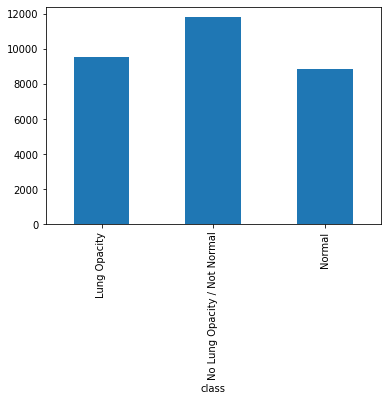

In [27]:
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

#### Combine Boxes and Labels

In [28]:
print(Bbox.head())
print(det_class_df.head())

                              patientId  Boxes
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6      1
1  000924cf-0f8d-42bd-9158-1af53881a557      1
2  000db696-cf54-4385-b10b-6b16fbb3f985      2
3  000fe35a-2649-43d4-b027-e67796d412e0      2
4  001031d9-f904-4a23-b3e5-2c088acd19c6      2
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


In [29]:
comb_bbox_df = pd.concat([Bbox, 
                        det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(5)

30227 combined cases


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


,patientId,Boxes,class
21584,d449d4c7-3359-40a4-b9ae-da2911ae2f34,1.0,Normal
22221,d9b9ecb8-e27f-4f0b-8a22-822243272131,1.0,No Lung Opacity / Not Normal
4212,3c674b10-76e4-457c-a17f-2407230b93a0,1.0,Lung Opacity
21846,d6807276-e6a7-474e-b490-7dcfc8da4179,1.0,No Lung Opacity / Not Normal
15564,9f765527-a937-42be-9e95-d673b2ad97e2,1.0,Lung Opacity


In [30]:

Merge_df = pd.concat([df, det_class_df['class']], axis = 1)
Merge_df.head()

,patientId,x,y,width,height,Target,Boxes,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity


Text(0.5, 1.0, 'Class and Target for Chest Exams')

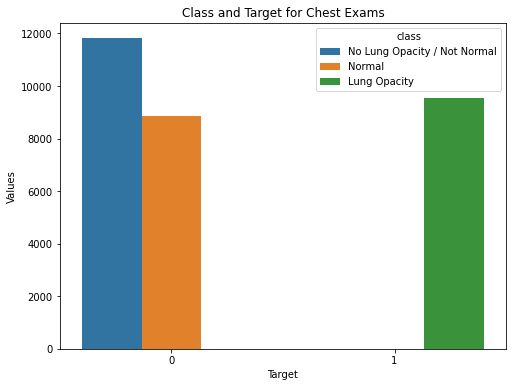

In [31]:
fig, ax = plt.subplots(nrows = 1, figsize = (8, 6))
Disp = Merge_df.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': Disp.values}, index = Disp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class)
plt.title('Class and Target for Chest Exams')

### Loading the Dicom Data

In [32]:
import zipfile
zf = "/content/drive/My Drive/rsna-pneumonia-detection-challenge.zip"
target_dir = "/content/drive/My Drive/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

OSError: ignored

In [33]:
train_path = '/content/drive/My Drive/pneumonia_revamped/stage_2_train_images'
test_path = '/content/drive/My Drive/pneumonia_revamped/stage_2_test_images'
valid_path = '/content/drive/My Drive/pneumonia_revamped/stage_2_sample_submission'

In [34]:
batch_size = 16 
#The dimension of the images we are going to define is 500x500 
img_height = 500
img_width = 500

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)


In [36]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [37]:
Dis_patientId = df['patientId'][0]
dcm_file = '/content/drive/My Drive/pneumonia_revamped/stage_2_train_images/'+'{}.dcm'.format(Dis_patientId)
dcm_data = pdcm.read_file(dcm_file)

print('Metadata of the image consists of \n', dcm_data)

Metadata of the image consists of 
 Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '190

In [38]:
import os
print('Count of iamges in training: {}.'.format(len(os.listdir('/content/drive/My Drive/pneumonia_revamped/stage_2_train_images'))))

Count of iamges in training: 26684.


In [39]:
from glob import glob
images = pd.DataFrame({'path': glob(os.path.join(train_path, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x:os.path.splitext(os.path.basename(x))[0])
print('Columns in the training images: {}'.format(list(images.columns)))


Columns in the training images: ['path', 'patientId']


In [40]:
### Merging the Data and Image
Merge_df = Merge_df.merge(images, on = 'patientId', how = 'left')
print('After merging the two dataframe, the training_data has {} rows and {} columns.'.format(Merge_df.shape[0], Merge_df.shape[1]))

After merging the two dataframe, the training_data has 30227 rows and 9 columns.


In [41]:
Merge_df.head()

,patientId,x,y,width,height,Target,Boxes,class,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/drive/My Drive/pneumonia_revamped/sta...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/drive/My Drive/pneumonia_revamped/sta...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/drive/My Drive/pneumonia_revamped/sta...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/content/drive/My Drive/pneumonia_revamped/sta...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/content/drive/My Drive/pneumonia_revamped/sta...


In [86]:
columns_to_add = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']
file_desc = pd.DataFrame(columns=column_list)
def parse_dicom_data(data_df, data_path):
  for col in columns_to_add:
    data_df[col] = None
  image_names = os.listdir('/content/drive/My Drive/pneumonia_revamped/stage_2_train_images/')
  
  for i, img_name in tqdm_notebook(enumerate(image_names)):
    imagepath = os.path.join('/content/drive/My Drive/pneumonia_revamped/stage_2_train_images/', img_name)
    data_img = dcm.read_file(imagepath)
    idx = (data_df['patientId'] == data_img.PatientID)
    data_df.loc[idx, 'Modality'] = data_img.Modality
    data_df.loc[idx, 'PatientAge'] = data_img.PatientAge
    data_df.loc[idx, 'PatientSex'] = data_img.PatientSex
    data_df.loc[idx, 'BodyPartExamined'] = data_img.BodyPartExamined
    data_df.loc[idx, 'ViewPosition'] = data_img.ViewPosition
    data_df.loc[idx, 'ConversionType'] = data_img.ConversionType
    data_df.loc[idx, 'Rows'] = data_img.Rows
    data_df.loc[idx, 'Columns'] = data_img.Columns
    data_df.loc[idx, 'PixelSpacing'] = str.format("{:4.3f}", data_img.PixelSpacing[0])

In [89]:
file_desc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Patient ID     0 non-null      object
 1   Patient Sex    0 non-null      object
 2   Patient's Age  0 non-null      object
 3   View Position  0 non-null      object
 4   Image Size     0 non-null      object
dtypes: object(5)
memory usage: 0.0+ bytes


#### Plotting Dicom Image Display

In [92]:
def show_dicom_images(data, df, img_path):
  img_data = list(data.T.to_dict().values())
  f, ax = plt.subplots(3, 3, figsize = (16, 18))
  
  for i, row in enumerate(img_data):
    image = row['patientId'] + '.dcm'
    path = os.path.join(img_path, image)
    data = pdcm.read_file(path)
    rows = df[df['patientId'] == row['patientId']]
    age = data.PatientAge
    sex = data.PatientSex
    part = data.BodyPartExamined
    vp = data.ViewPosition
    modality = data.Modality
    data_img = pdcm.dcmread(path)
    ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                            .format(row['patientId'], age, sex, part,
                                    vp, modality, row['Target'],
                                    row['class'], row['x'],
                                    row['y'], row['width'],
                                    row['height']))
    box_data = list(rows.T.to_dict().values())
    
    for j, row in enumerate(box_data):
      ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                                        width = row['width'], height = row['height'],
                                        color = 'blue', alpha = 0.15))
  plt.show()

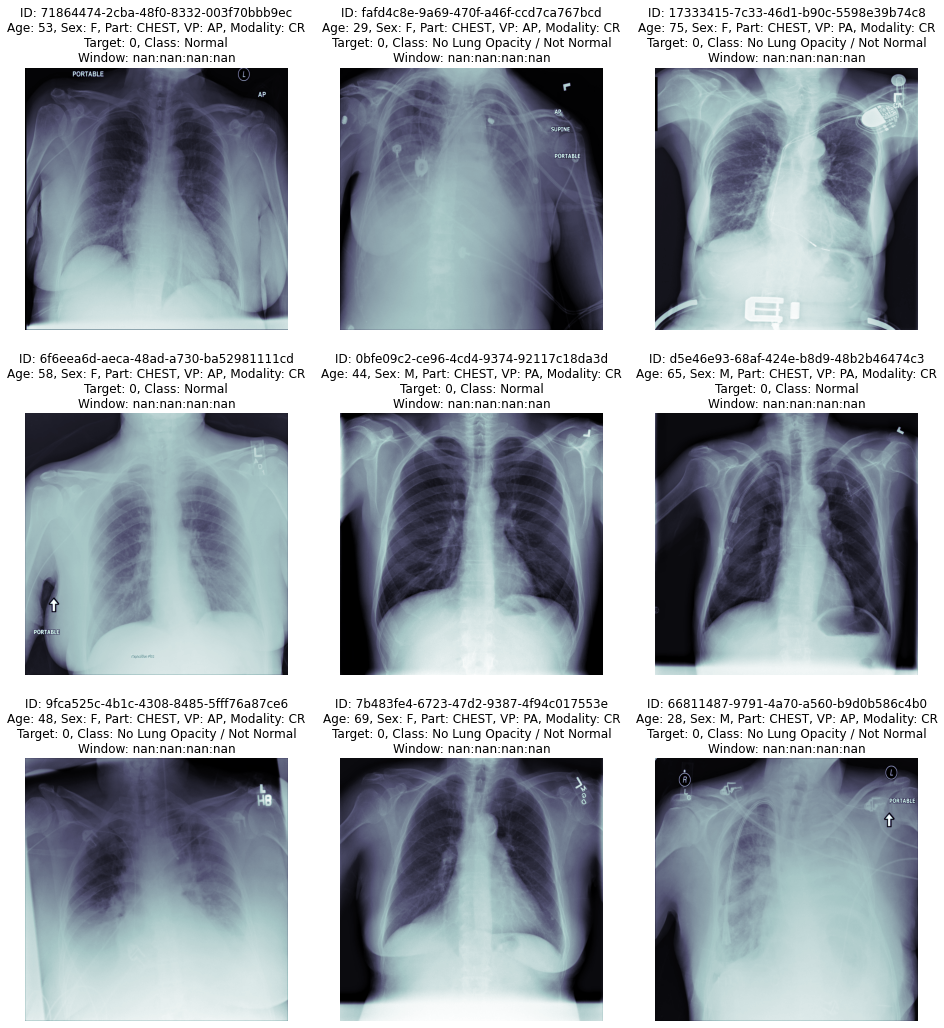

In [93]:
from matplotlib.patches import Rectangle
show_dicom_images(data = Merge_df.loc[(Merge_df['Target'] == 0)].sample(9),
                  df = Merge_df, img_path = '/content/drive/My Drive/pneumonia_revamped/stage_2_train_images/')

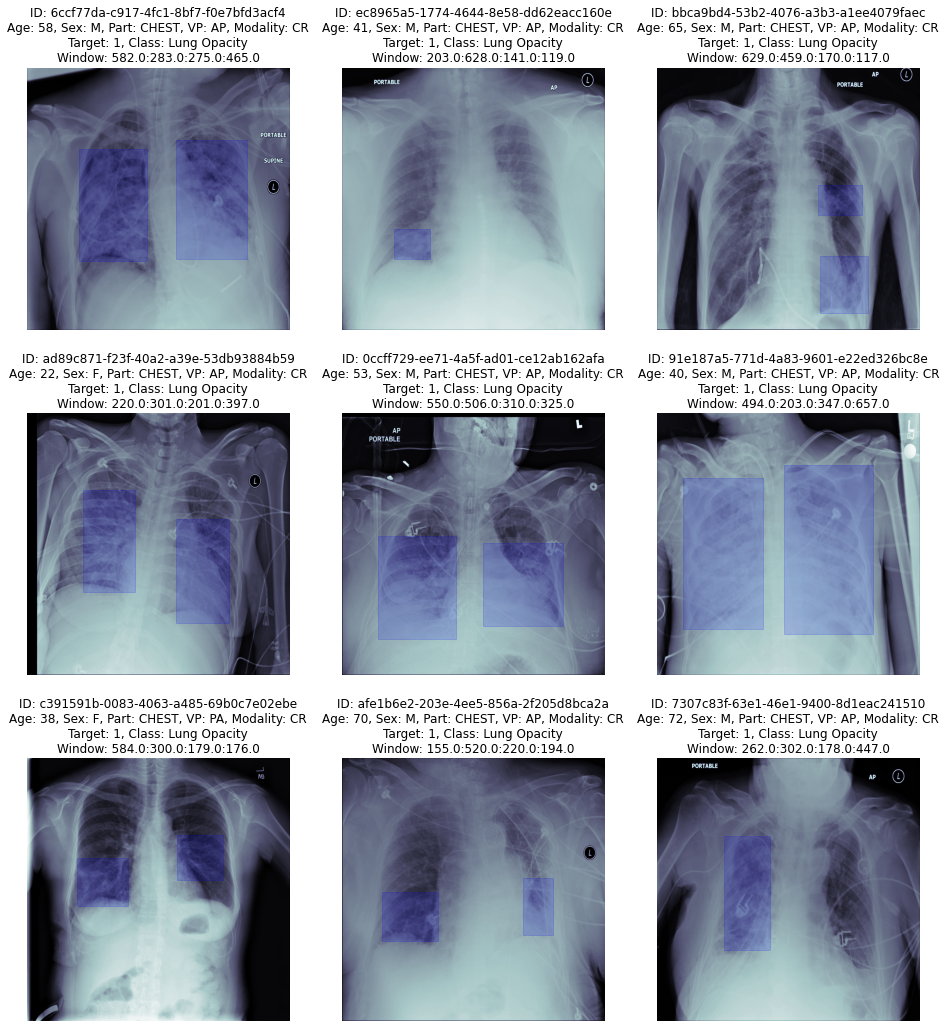

In [94]:
show_dicom_images(data = Merge_df.loc[(Merge_df['Target'] == 1)].sample(9),
                  df = Merge_df, img_path = '/content/drive/My Drive/pneumonia_revamped/stage_2_train_images/')

In [95]:
import seaborn as sns
sns.set(color_codes=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


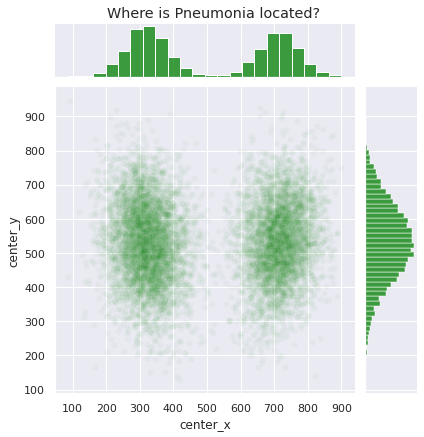

In [97]:
centers = (Merge_df.dropna(subset=['x'])
           .assign(center_x=Merge_df.x + Merge_df.width / 2, 
                   center_y=Merge_df.y + Merge_df.height / 2))
ax = sns.jointplot("center_x", "center_y", data=centers, height=6, alpha=0.03, color="green")
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)

In [100]:
import multiprocessing

def get_info(patientId, root_dir=train_path):
    file_name = os.path.join(root_dir, f'{patientId}.dcm')
    dicom_data = dcm.read_file(file_name)
    return {'age': dicom_data.PatientAge, 
            'gender': dicom_data.PatientSex,
            'view_position': dicom_data.ViewPosition,
            'id': os.path.basename(file_name).split('.')[0],
            'pixel_spacing': float(dicom_data.PixelSpacing[0]),
            'mean_black_pixels': np.mean(dicom_data.pixel_array == 0)}

patient_ids = list(Merge_df.patientId.unique())
with multiprocessing.Pool(4) as pool:
    result = pool.map(get_info, patient_ids)
    


In [102]:
demo = pd.DataFrame(result)
demo['age'] = demo['age'].astype(int)
demo['gender'] = demo['gender'].astype('category')
demo['view_position'] = demo['view_position'].astype('category')

labels = (Merge_df.merge(demo, left_on='patientId', right_on='id', how='left').drop(columns='id'))

In [103]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import pydicom as dcm
import pandas as pd
import pickle

In [104]:
data = []
bbox_coords = []
target_label = []
img_paths = []


In [105]:
label_data=labels[0:10000]

In [106]:
label_data[2:5]

,patientId,x,y,width,height,Target,Boxes,class,path,age,gender,view_position,pixel_spacing,mean_black_pixels
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/drive/My Drive/pneumonia_revamped/sta...,19,M,AP,0.168,0.000000
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/content/drive/My Drive/pneumonia_revamped/sta...,28,M,PA,0.143,0.011372
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/content/drive/My Drive/pneumonia_revamped/sta...,32,F,AP,0.139,0.002634


In [62]:
ytrain = pd.DataFrame(det_class_df, columns=["Target"])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(Merge_df, ytrain, test_size=0.30, random_state=3)

In [66]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

In [67]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [101]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

AttributeError: ignored

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import pydicom as dcm
import pandas as pd
import pickle

In [48]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [49]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

In [50]:
filters = 32
kernel_size = (3,3)
height = 500
width = 500
Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    activation=None,
    input_shape=(height,width))

In [51]:
MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
    )

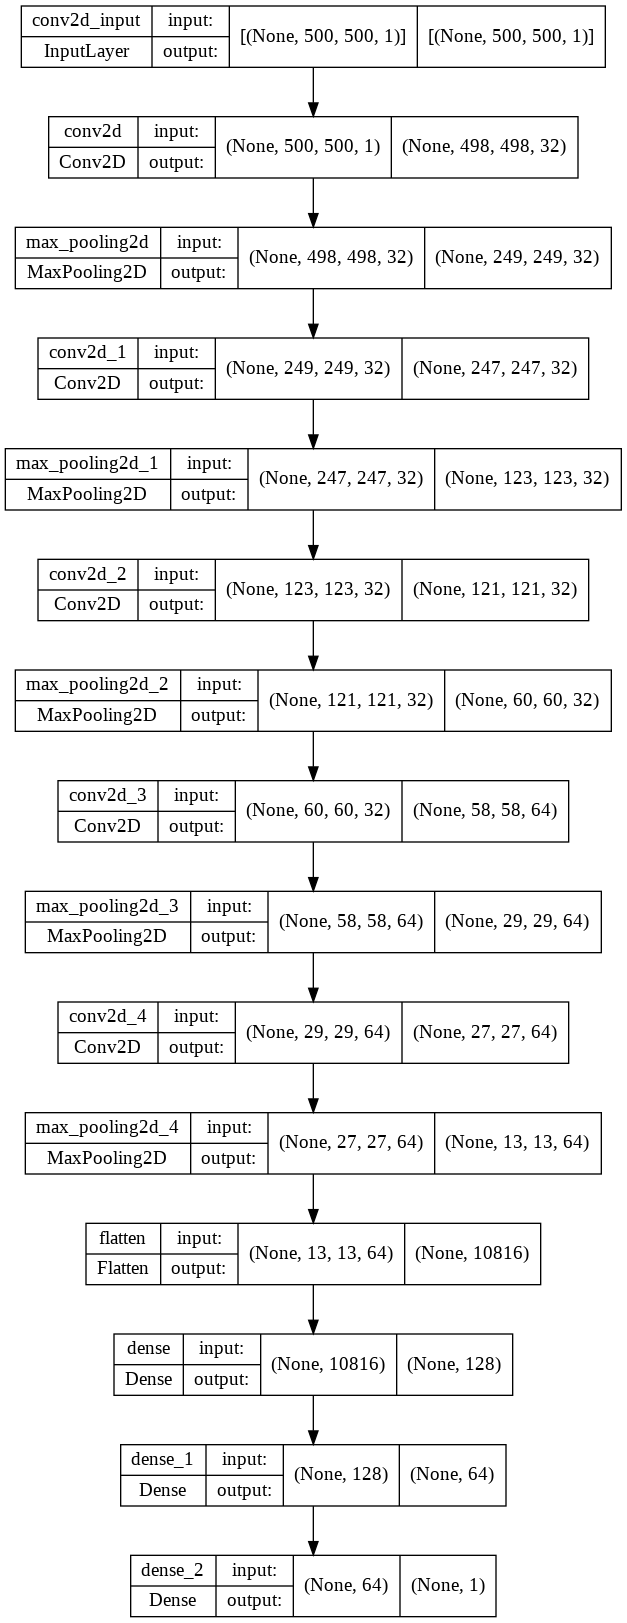

In [52]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [54]:
cnn.fit(X_train, y_train)

ValueError: ignored

In [ ]:
for i in range(len(label_data)):
  filename=label_data.iloc[i,0]
  startX = label_data.iloc[i,1]
  startY = label_data.iloc[i,2]
  endX = label_data.iloc[i,3]
  endY = label_data.iloc[i,4]
  label= label_data.iloc[i,5]
  img_path = os.path.join('/content/drive/My Drive/pneumonia_revamped/stage_2_train_images/', filename+".dcm")##Change the path to your directory where images are located
  img = dcm.dcmread(img_path).pixel_array

  h = float(img.shape[0])
  w = float(img.shape[1])

  # Scale bounding box coordinates relative to the image
  startX = float(startX)/w
  startY = float(startY)/h
  endX = float(endX)/w
  endY = float(endY)/h
  img = cv2.resize(img,(224,224))
  data.append(img)
  bbox_coords.append((startX,startY,endX,endY))
  target_label.append(label)
  img_paths.append(img_path)
